<a href="https://colab.research.google.com/github/abyanjan/Pytorch-Deep-Learning/blob/master/Cifar10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CIFAR10 Classification with CNN and Pytorch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms

In [ ]:
# device configuration
print(torch.cuda.is_available())

True


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Creating Transformers for image transformation**

In [ ]:
# dataset has PIL images in the range [0,1]
# we are transforming them to pytorch tensors and be in the range [-1, 1]

train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

test_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

In [ ]:
# load data
train_dataset = torchvision.datasets.CIFAR10(root='/data',train=True, transform=train_transform, download=True)

test_dataset = torchvision.datasets.CIFAR10(root='/data', train=False, transform=test_transform, download=True)


Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


In [ ]:
# creating data loader
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# classes in the data
classes = train_dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


**Visualize some images**

In [ ]:
def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [ ]:
def imshow(img):
  #img = img/2 +0.5 
  # unnormalize
  imag = inverse_normalize(img, mean = (0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
  np_img = img.numpy()
  plt.figure(figsize=(10,5))
  plt.imshow(np.transpose(np_img,(1,2,0)))
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


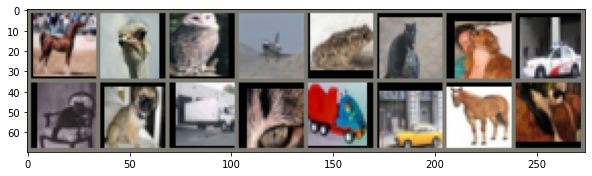

In [ ]:
# get some randome images
images, labels = iter(train_dataloader).next()

# show the images
imshow(torchvision.utils.make_grid(images))

**Creating the CNN model**

In [ ]:
class CNN(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
       """Perform forward."""
       # conv layers
       x = self.conv_layer(x)
            
       # flatten
       x = x.view(x.size(0), -1)
            
       # fc layer
       x = self.fc_layer(x)

       return x  

In [ ]:
#Hyperparameters
num_epochs = 15
batch_size = 16
learning_rate = 0.0001

In [ ]:
# initialize the model and move to the device
model = CNN().to(device)

In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

**Training the model**

In [ ]:
n_total_steps = len(train_dataloader)

loss_performance = []
accuracy_performance = []

for epoch in range(num_epochs):
  epoch_loss = 0.0
  epoch_acc = 0.0
  running_loss = 0.0
  running_acc = 0.0

  for i ,(images, labels) in enumerate(train_dataloader):
    #move the images to the device
    images = images.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    pred = torch.argmax(outputs, 1)
    acc = (pred==labels).sum()/batch_size

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    running_acc += acc

    epoch_acc += acc
    epoch_loss += loss.item()

    if (i+1) % 1000 == 0: # print every 1000 mini-batches
      print(f'[{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {running_loss/1000:.4f}, Accuracy: {running_acc/1000:.4f}')
      running_loss = 0.0
      running_acc = 0.0
  
  accuracy_performance.append(epoch_acc/n_total_steps)
  loss_performance.append(epoch_loss/n_total_steps)

print("Finished Traning !!!")

[1/15], Step [1000/3125], Loss: 1.6843, Accuracy: 0.3694
[1/15], Step [2000/3125], Loss: 1.3352, Accuracy: 0.5092
[1/15], Step [3000/3125], Loss: 1.1181, Accuracy: 0.6003
[2/15], Step [1000/3125], Loss: 0.9809, Accuracy: 0.6533
[2/15], Step [2000/3125], Loss: 0.9033, Accuracy: 0.6830
[2/15], Step [3000/3125], Loss: 0.8366, Accuracy: 0.7043
[3/15], Step [1000/3125], Loss: 0.7730, Accuracy: 0.7316
[3/15], Step [2000/3125], Loss: 0.7456, Accuracy: 0.7386
[3/15], Step [3000/3125], Loss: 0.7057, Accuracy: 0.7533
[4/15], Step [1000/3125], Loss: 0.6504, Accuracy: 0.7714
[4/15], Step [2000/3125], Loss: 0.6436, Accuracy: 0.7750
[4/15], Step [3000/3125], Loss: 0.6186, Accuracy: 0.7866
[5/15], Step [1000/3125], Loss: 0.5756, Accuracy: 0.7974
[5/15], Step [2000/3125], Loss: 0.5663, Accuracy: 0.8035
[5/15], Step [3000/3125], Loss: 0.5554, Accuracy: 0.8059
[6/15], Step [1000/3125], Loss: 0.5119, Accuracy: 0.8214
[6/15], Step [2000/3125], Loss: 0.5181, Accuracy: 0.8213
[6/15], Step [3000/3125], Loss:

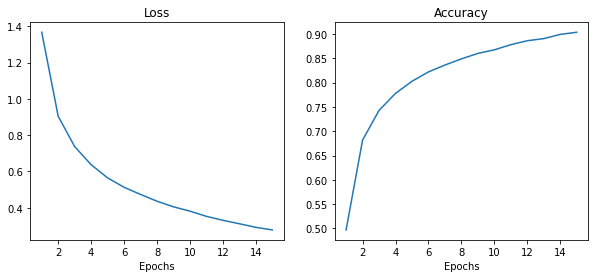

In [ ]:
# plotting training performance curve
epochs = range(1, 16)
fig = plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot( epochs,  loss_performance);
plt.title('Loss');
plt.xlabel('Epochs');

plt.subplot(1,2,2)
plt.plot( epochs,  accuracy_performance);
plt.title('Accuracy');
plt.xlabel('Epochs');


**Evaluation on test data**

In [ ]:
# model evaluation on test data
model.eval()

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]

  predictions = []
  actual = []

  for images, labels in test_dataloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    # take the maximum predicted labels
    predicted = torch.argmax(outputs, 1)

    # store the predictions and actual labels
    predictions.extend(predicted.tolist())
    actual.extend(labels.tolist())

    # calculate total and class accuracy
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

    for i in range(batch_size):
      label = labels[i]
      pred = predicted[i]
      
      if label == pred:
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  acc = 100.0 * n_correct/n_samples
  print(f'Accuracy for the test dataset: {acc:.4f}%')
  print()

  # print accuracy for each class
  for i in range(10):
    acc_class = 100.0 * n_class_correct[i]/n_class_samples[i]
    print(f'Accuracy for the Class:{classes[i]}: {acc_class:.4f}%')



Accuracy for the test dataset: 87.7300%

Accuracy for the Class:airplane: 88.9000%
Accuracy for the Class:automobile: 94.2000%
Accuracy for the Class:bird: 75.3000%
Accuracy for the Class:cat: 72.2000%
Accuracy for the Class:deer: 88.4000%
Accuracy for the Class:dog: 88.4000%
Accuracy for the Class:frog: 92.6000%
Accuracy for the Class:horse: 90.7000%
Accuracy for the Class:ship: 94.7000%
Accuracy for the Class:truck: 91.9000%


**Confusion Matrix**

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
assert(len(predictions)==len(actual))


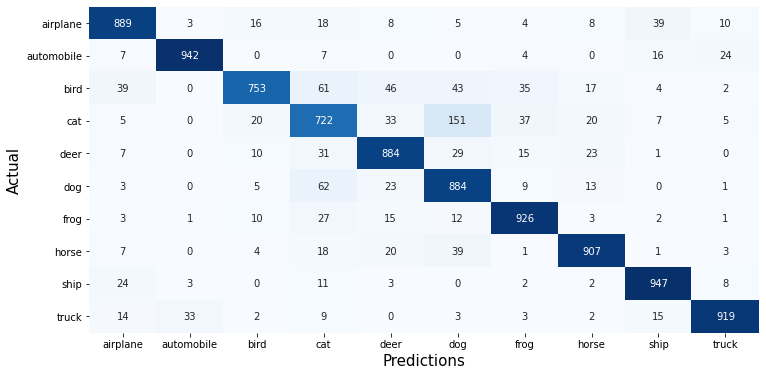

In [ ]:
conf_mat = confusion_matrix(actual, predictions)
#conf_mat
plt.figure(figsize=(12,6))
sns.heatmap(conf_mat, annot = True, cmap='Blues', cbar=False,fmt='.4g',xticklabels=classes,yticklabels=classes);
plt.xlabel('Predictions',size=15 );
plt.ylabel('Actual',size=15);